In [1]:
import MINE.MINE_net as MINE
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import time

from IPython.display import display, clear_output

I want to make a network and train it to convergence for a range of data samples and regularizations.

In [3]:
def build_stuff(nshape,gradreg,nn = 5,timescale=10,unbias_grad = False,reuse = False,tag = "MINE"):
    
    dat = tf.placeholder(tf.float32,shape = [nshape,nn])
    n1 = tf.placeholder(tf.float32,shape = [nshape,nn])
    n2 = tf.placeholder(tf.float32,shape = [nshape,nn])

    dat1 = dat + n1
    dat2 = dat + n2
    
    mine,test = MINE.get_MINE(dat1,dat2,grad_timescale = timescale,unbias_grad = unbias_grad,reuse = reuse,tag = tag)

    mi,inp = MINE.get_MINE_grad_vars(dat1,dat2,reuse = True,tag = tag)
    grads = tf.gradients(mi,inp)
    minegradreg = tf.reduce_sum([tf.reduce_mean(g**2,axis = 0) for g in grads])

    loss = -mine + gradreg * minegradreg
    
    return loss, mine,dat,n1,n2,test
    
    

In [4]:
nn = 10

cov = np.eye(nn)*(1+.1)
ccon = np.eye(nn)*(.1)

MI = (np.log(np.linalg.det(cov)) + np.log(np.linalg.det(ccon)))/2 + nn*(1. + np.log(2*np.pi))

print(MI)

17.3423960981


In [5]:
OUT = []

In [6]:
j = 0
for gtime in [True]:
    j += 1
    tf.reset_default_graph()
    np.random.seed(0)
    tf.set_random_seed(0)
    nsam = 100
    ndim = 10
    ntot = 10000
    grad_reg = 0

    grad_timescale = 10
    
    tag = "{}_{}_{}_{}_{}".format(grad_reg,gtime,ntot,ndim,j)
    print(tag)
    loss,mine,dat,nn1,nn2,test = build_stuff(nsam,grad_reg,ndim,grad_timescale,tag = tag,reuse = False,unbias_grad = gtime)

    alldat = np.random.normal(0,1,[ntot,ndim])
    n1 = np.random.normal(0,.1,[ntot,ndim])
    n2 = np.random.normal(0,.1,[ntot,ndim])

    adam = tf.train.AdamOptimizer(learning_rate = .0001)
    train = adam.minimize(loss)
    
    if gtime == True:
        with tf.variable_scope("",reuse = True):
            unbiased_grad = tf.get_variable(tag + "unbias_MINE_grad_{}".format(grad_timescale))
            #ugrad_test = tf.get_variable(tag + "unbias_MINE_grad_test_{}".format(grad_timescale))
            ugrad_test = tf.get_variable(tag + "unbias_MINE_grad_test_{}".format(grad_timescale))


    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    sess = tf.Session()
    sess.run(init)
    out = []
    ilist = range(len(alldat))
    for step in range(500):
        ii = np.random.choice(ilist,nsam)
        samp = alldat[ii]
        no1 = n1[ii]
        no2 = n2[ii]
        
        if gtime:
            loss_out,MINEout,u1,u2,TT = sess.run([train,mine,unbiased_grad,ugrad_test,test],{dat:samp,nn1:no1,nn2:no2})
        else:
            loss_out,MINEout = sess.run([train,mine],{dat:samp,nn1:no1,nn2:no2})
        if (step + 1) % 50==0:
            clear_output(wait=False)
            if gtime:
                display(print("{}\t{}\t{}\t{}\t{}".format(step,np.mean(out[-10:]),u1,u2,TT)))
            else:
                display(print("{}\t{}".format(step,np.mean(out[-10:]))))
        
        out.append(MINEout)

    OUT.append([nsam,ndim,ntot,gtime,grad_reg,out])

    print(np.mean(out[-1000:]))
    print(np.std(out[-1000:]))

    plt.plot(range(len(out)),out)
    plt.show()
    sess.close()

0_True_10000_10_1


ValueError: Trying to share variable 0_True_10000_10_1_layer_0/kernel, but specified shape (20, 10) and found shape (20, 64).

In [ ]:
-0.00248767
0.00194686

def esmooth(x,T = 30):
    t = np.exp(-1./T)
    out = [x[0]]
    for k in x[1:]:
        out.append(out[-1]*t + (1.-t)*k)
    return np.array(out)

No handles with labels found to put in legend.


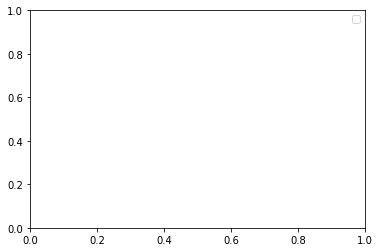

In [7]:
plt.clf()
jj = 0
for o in OUT:
    
    plt.plot(range(len(o[-1])),esmooth(o[-1],T = 10),label = (np.mean(o[-1][-1000:]),np.std(o[-1][-1000:])))
    jj += 1
    
plt.legend()
plt.show()